<a href="https://colab.research.google.com/github/ciaopeps/RBCxImperial/blob/master/imperialXrbc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Preprocessing

In [ ]:
import pandas as pd
import os
import urllib
import gensim
from spacy.lang.en.stop_words import STOP_WORDS as en
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import spacy 
import matplotlib.pyplot as plt


In [ ]:
# !python3 -m spacy download it_core_news_sm MUST RUN

In [ ]:
def mining(real):
    # removing duplicates
    real = real.drop_duplicates(['text'])
    texts = real.text
    # removing publisher
    articles = []
    for text in texts:
        try:
            articles.append(text.split('-', maxsplit=1)[1])
        except:
            articles.append([text])
    real['clean'] = articles
    #stopwords are downloaded from the spacy library and extended using existing databases
    stop_words = list(en)
    url = "https://gist.githubusercontent.com/deekayen/4148741/raw/98d35708fa344717d8eee15d11987de6c8e26d7d/1-1000.txt"
    file = urllib.request.urlopen(url)
    stop_ext = [line.decode("utf-8").strip() for line in file]
    stop_words = stop_words + stop_ext
    stop_words.extend(
        ['use', 'per', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try',
         'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want',
         'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])
    #loading the spacy lemmatizer 
    lemma = spacy.load('en_core_web_sm', disable=['parser', 'Ner'])

    #function that tokenizes the text
    def token(sentences):
        for sentence in sentences:
            yield (gensim.utils.simple_preprocess(str(sentence), deacc=True))
    # creating bigrams and trigrams
    def bigram_trigram(t):
        bigram = gensim.models.Phrases(t)
        trigram = gensim.models.Phrases(bigram[t])
        bigram_ = gensim.models.phrases.Phraser(bigram)
        trigram_ = gensim.models.phrases.Phraser(trigram)
        texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in t]
        bi = [bigram_[text] for text in texts]
        tri = [trigram_[bigram_[b]] for b in bi]
        return tri
    # preprocessing and lemmatization
    def processing(texts, stop_words=stop_words):
        texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
        output = []
        for text in texts:
            doc = lemma(" ".join(text))
            output.append([token.lemma_ for token in doc])
        # remove stopwords once more after lemmatization
        output = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in output]
        return output

    tokens = list(token(articles))
    bi_tri = bigram_trigram(tokens)
    final_data = processing(bi_tri)
    real['clean'] = [' '.join(final) for final in final_data]
    return real





print('log:: Start loading files...')

real = pd.read_csv(os.path.join('data', 'True.csv'))
fake = pd.read_csv(os.path.join('data', 'Fake.csv'))
print('log:: Files loaded')

real = mining(real)
fake = mining(fake)
real['real'] = 1
fake['fake'] = 1
dataset = pd.concat([real, fake]).fillna(0)

print('log:: Data mined')
#creating a sample dataset which will be used to test the program
dataset.sample(10).to_csv(os.path.join('data', 'dataset_sample.csv'), encoding='utf8', sep=',', index=True)
dataset.to_csv(os.path.join('data', 'dataset.csv'), encoding='utf8', sep=',', index=True)
print('log:: Dataset exported')

In [ ]:
#load the proprocessed dataset to avoid running the proprocessing function again
dataset = pd.read_csv('/content/drive/My Drive/PhD RBC/data/dataset.csv')

In [ ]:
dataset.head()

,Unnamed: 0,title,text,subject,date,clean,real,fake
0,0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",conservative republican faction congress vote ...,1.0,0.0
1,1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",transgender enlist military monday federal_cou...,1.0,0.0
2,2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",counsel investigation links russia president t...,1.0,0.0
3,3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",trump campaign australian diplomat russia poli...,1.0,0.0
4,4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",postal_service friday package amazon_amzn onli...,1.0,0.0


# Fake News Classifier

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Embedding
from tensorflow.keras.optimizers import Adam
import os

Uploading the pretrained embeddings based on English Wikipedia articles [https://nlp.stanford.edu/projects/glove](https://nlp.stanford.edu/projects/glove). 

Creating the `embedding index` which  maps each word to a vector of size 100. 

Process the cleaned texts and transform them into sequences of integers:

* Use `Tokenizer` from `tensorflow.keras.preprocessing.text` to generate the tokenizer and the word_index dictionary. 
* Use the word_index dictionary to map text tokens into integers.  

In [ ]:
# List of possible labels
possible_labels = ['real','fake']
# Matrix of labels of shape (N, K)
labels = dataset[possible_labels].values
labels = np.asarray(labels)
# Set Hyperparameters
V = 20000
texts = dataset.clean.astype(str)
# Create the Tokenizer
tokenizer = Tokenizer(num_words=V)
# Fit the tokenizer on the texts to create the word_index dictionary
tokenizer.fit_on_texts(texts)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
# From texts to sequences of integers 
sequences = tokenizer.texts_to_sequences(texts)

Found 101606 unique tokens.


`pad_sequences` from `tensorflow.keras.preprocessing.sequence`, transform the list of sequences into an `(N, T)` tensor. (Set `T = 500`). 
Shuffle and split the data into train and test sets.

In [ ]:

# Set hyperparameters
T = 500
# Pad sequences
data = pad_sequences(sequences, maxlen= T)
# Shuffle indices
indices = np.arange(len(data))
np.random.shuffle(indices)

# New data
data = data[indices]

# New labels
labels = labels[indices]
print('Shape of data tensor:', data.shape)
# Split 
split = int(.8 * len(texts))
train_data = data[:split]
train_labels = labels[:split]

test_data = data[split:]
test_labels = labels[split:]

Shape of data tensor: (44898, 500)


Uploading the pretrained embeddings based on English Wikipedia articles [https://nlp.stanford.edu/projects/glove](https://nlp.stanford.edu/projects/glove). 

Creating the `embedding index` which  maps each word to a vector of size 100. 

In [ ]:
# Directory of the Embedding file

dir_glove = '/content/drive/My Drive/PhD RBC/glove'

# Create the dictionary
embedding_index = {}

f = open(os.path.join(dir_glove, "glove.6B.100d.txt"), encoding = "utf8")
for line in f:
    # Split each line
    values = line.split()
    # Get the word
    word = values[0]
    # Get the embedding vector 
    embedding_vector = np.asarray(values[1:], dtype = "float32")
    # Append the dictionary
    embedding_index[word] = embedding_vector
f.close()
# The embedding dimension
D = 100

Embedding_matrix of shape (V, D) where D is the embedding dimension and V the vocabulary size, both defined above.
In this matrix, the row number k will be represented by the embedding vector associated with the word of index k in the embedding_index dictionary.
`Embedding` from `tensorflow.keras.layers` generates the embedding layer.
This layer transforms an `(N, T)` tensor of integers into an `(N, T, D)` tensor. Finally the embedding matrix is loaded into the embedding layer. 

In [ ]:


# Initilize the embedding matrix with zeros
embedding_matrix = np.zeros((V, D))

# Loop through all the elements of the word_index dictionary 
for word, i in word_index.items():
    if i < V:
        # Get the embedding vector or None 
        embedding_vector = embedding_index.get(word) 
        # Update one row of the embedding matrix
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            
embedding_layer = Embedding(
  V,
  D,
  weights=[embedding_matrix],
  input_length=T,
  trainable=False
)

Creating the model with the embedding layer. 

In [ ]:
possible_labels = [0,1]
# Set hyperparameters
d_1 = 64 # output dimension of the first LSTM layer
d_2 = 32 # output dimension of the second LSTM layer
d_3 = len(possible_labels) # Output dimension of the last layer 

# Define the two lstm layers
lstm_1 = LSTM(d_1, return_sequences = True)
lstm_2 = LSTM(d_2, return_sequences = False)

# The input layer
input_layer = Input(shape=(T,), dtype = "int32") # (N, T)

# Apply the embeddin lyer
x = embedding_layer(input_layer) # (N, T, D)

# Apply the first LSTM layer
y = lstm_1(x) # (N, T, d_1)

# Apply the second LSTM layer
h_T = lstm_2(y) # (N, d_2)

# Apply the dense layer 
output = Dense(d_3, activation = "sigmoid")(h_T) # (N, d_3)

# Define the model
model = Model(input_layer, output)
opt = Adam(
    learning_rate=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
    name='Adam'
)
model.compile(optimizer=opt,
              loss = "binary_crossentropy",
              metrics = ["accuracy"],)
model.summary()


Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 500)]             0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 500, 100)          2000000   
_________________________________________________________________
lstm_7 (LSTM)                (None, 500, 64)           42240     
_________________________________________________________________
lstm_8 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 66        
Total params: 2,054,722
Trainable params: 54,722
Non-trainable params: 2,000,000
_________________________________________________________________


 fitting the model

In [ ]:

callbacks_list = [
                  EarlyStopping( # Interrupt the training when there is no more improvement
                      monitor = "val_accuracy", # Metric to monitor
                      patience = 5 # Number of epochs before interrupting the training if there is no improvement
                  ),
                  ReduceLROnPlateau(
                      monitor = "val_loss", # metric to monitor
                      factor = 0.1, # Multiply the lr by factor when triggered
                      patience = 5 # Number of epochs of non improvement before the callback is triggered
                  )
]

history = model.fit(train_data, 
                    train_labels, 
                    epochs = 25, 
                    batch_size=512, 
                    callbacks = callbacks_list,
                    validation_split=.2)

Epoch 1/25
57/57 [==============================] - 6s 103ms/step - loss: 0.3482 - accuracy: 0.8495 - val_loss: 0.3268 - val_accuracy: 0.8653
Epoch 2/25
57/57 [==============================] - 6s 102ms/step - loss: 0.3212 - accuracy: 0.8622 - val_loss: 0.3165 - val_accuracy: 0.8697
Epoch 3/25
57/57 [==============================] - 6s 102ms/step - loss: 0.3105 - accuracy: 0.8671 - val_loss: 0.3086 - val_accuracy: 0.8724
Epoch 4/25
57/57 [==============================] - 6s 102ms/step - loss: 0.3045 - accuracy: 0.8690 - val_loss: 0.3019 - val_accuracy: 0.8768
Epoch 5/25
57/57 [==============================] - 6s 102ms/step - loss: 0.2967 - accuracy: 0.8737 - val_loss: 0.2969 - val_accuracy: 0.8779
Epoch 6/25
57/57 [==============================] - 6s 102ms/step - loss: 0.2885 - accuracy: 0.8778 - val_loss: 0.2938 - val_accuracy: 0.8789
Epoch 7/25
57/57 [==============================] - 6s 102ms/step - loss: 0.2832 - accuracy: 0.8791 - val_loss: 0.2898 - val_accuracy: 0.8814
Epoch 

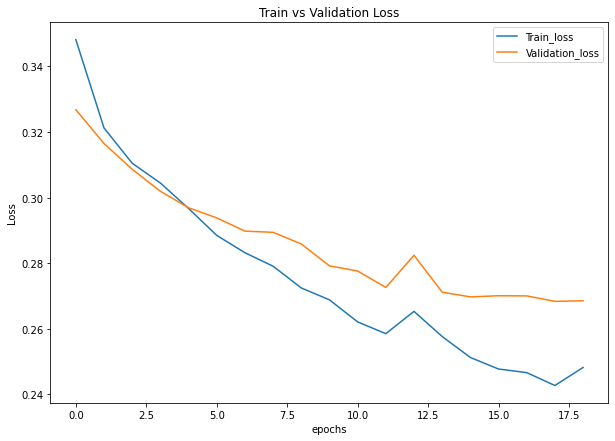

In [ ]:
# Evaluate the model 
# model.evaluate(test_data, test_labels)
fig, ax = plt.subplots(figsize = (10, 7))
plt.plot(history.history["loss"], label = "Train_loss")
plt.plot(history.history["val_loss"], label = "Validation_loss")
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.title("Train vs Validation Loss")
plt.legend()
plt.show()

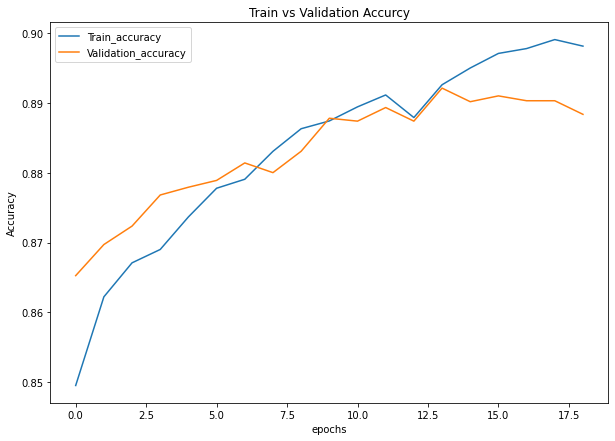

In [ ]:
fig, ax = plt.subplots(figsize = (10, 7))
plt.plot(history.history["accuracy"], label = "Train_accuracy")
plt.plot(history.history["val_accuracy"], label = "Validation_accuracy")
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.title("Train vs Validation Accurcy")
plt.legend()
plt.show()

# Topic modeling 

In [ ]:
import pandas as pd
import gensim
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model
import tensorflow as tf
import gensim.corpora as corpora
import matplotlib.pyplot as plt


In order to give background knowledge about the article I estimate a topic model using a Latent Dirichlet Allocation. The topics are then used as labels for a topic classifier. 
This model is trained on the articles from the original True dataset. 

In [ ]:
lda_data = dataset[dataset['real'] == 1] #extract real articles
texts = lda_data.clean.astype(str) #extracting the preprocess text
texts = [list(text.split(" ")) for text in texts]
id2word = corpora.Dictionary(texts) #generating id2word dictionary
corpus = [id2word.doc2bow(text) for text in texts]#generating corpus
print('Log:: LDA database created')

Log:: LDA database created


Downloading the mallet packages. This is used to estimated the LDA model. 

In [ ]:
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip mallet-2.0.8.zip
os.environ['MALLET_HOME'] = '/content/mallet-2.0.8'
mallet_path = '/content/mallet-2.0.8/bin/mallet' # you should NOT need to change this 

--2020-08-09 23:32:33--  http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Resolving mallet.cs.umass.edu (mallet.cs.umass.edu)... 128.119.246.70
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16184794 (15M) [application/zip]
Saving to: ‘mallet-2.0.8.zip’

mallet-2.0.8.zip    100%[===================>]  15.43M  11.4MB/s    in 1.4s    

2020-08-09 23:32:35 (11.4 MB/s) - ‘mallet-2.0.8.zip’ saved [16184794/16184794]

Archive:  mallet-2.0.8.zip
   creating: mallet-2.0.8/
   creating: mallet-2.0.8/bin/
  inflating: mallet-2.0.8/bin/classifier2info  
  inflating: mallet-2.0.8/bin/csv2classify  
  inflating: mallet-2.0.8/bin/csv2vectors  
  inflating: mallet-2.0.8/bin/mallet  
  inflating: mallet-2.0.8/bin/mallet.bat  
  inflating: mallet-2.0.8/bin/mallethon  
  inflating: mallet-2.0.8/bin/prepend-license.sh  
  inflating: mallet-2.0.8/bin/svmlight2vectors  
  inflating: mallet-2.0.8/bin/text2classi

In order to find the optimal number of topics I generate several models. I then compute their coherence value and compare in order to find the right model

In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):

    # dictionary : Gensim dictionary
    # corpus : Gensim corpus
    # texts : cleaned tex
    # limit : max num of topics
    # outputs a list containing the models and their respective coherence value


    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        print('log:: done', num_topics)

    return model_list, coherence_values

In [ ]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=texts, start=2, limit=40, step=6)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


log:: done 2
log:: done 8
log:: done 14
log:: done 20
log:: done 26
log:: done 32
log:: done 38


The graph below represents the change in the coherence score as the number of topics increases. Ideally, we want to choose the number of topics before the line flattens. After that point, an extra topic is not adding any more useful information. 


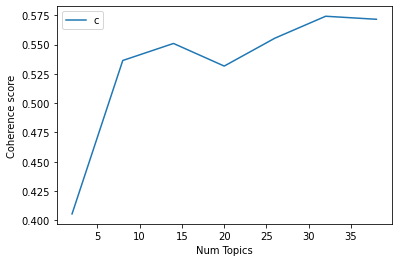

In [ ]:
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.4055
Num Topics = 8  has Coherence Value of 0.5364
Num Topics = 14  has Coherence Value of 0.5509
Num Topics = 20  has Coherence Value of 0.5316
Num Topics = 26  has Coherence Value of 0.5555
Num Topics = 32  has Coherence Value of 0.5741
Num Topics = 38  has Coherence Value of 0.5715


In [ ]:
optimal_model = model_list[1]

The function below generates the topic dataframe where for each document it indicates the dominant topic and the topic keywords.

In [ ]:
def format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=optimal_model):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=texts)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Keywords,Text
0,0,5.0,"bill, congress, senate, percent, billion, repu...","[conservative, republican, faction, congress, ..."
1,1,2.0,"court, vote, government, election, ban, presid...","[transgender, enlist, military, monday, federa..."
2,2,3.0,"report, official, investigation, department, r...","[counsel, investigation, links, russia, presid..."
3,3,3.0,"report, official, investigation, department, r...","[trump, campaign, australian, diplomat, russia..."
4,4,5.0,"bill, congress, senate, percent, billion, repu...","[postal_service, friday, package, amazon_amzn,..."
5,5,5.0,"bill, congress, senate, percent, billion, repu...","[friday, kick, republican, government, spendin..."
6,6,4.0,"trump, clinton, campaign, president, republica...","[thursday, fairly, treat, counsel, investigati..."
7,7,6.0,"government, eu, britain, leader, percent, parl...","[fake_news, approval_rating, foxandfriend, rat..."
8,8,6.0,"government, eu, britain, leader, percent, parl...","[america, ly, lnpkaq, est, eve, global_warme, ..."
9,9,4.0,"trump, clinton, campaign, president, republica...","[alabama, secretary, john, merrill, certify, e..."


Extract labels for the topic classifiers. The target matrix is the result of OneHotEcoding the topic output from the LDA model. 

Based on the fake news classifier above I build a similar model. This time it is going to be a multiclass classification model. 

In [68]:
# List of possible labels
possible_labels = df_dominant_topic['Dominant_Topic'].unique()

# Matrix of labels of shape (N, K)
targets = df_dominant_topic['Dominant_Topic'].values.astype(str) #extract dominant topic for each article
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = targets.reshape(len(targets), 1)
labels = onehot_encoder.fit_transform(integer_encoded)

In [70]:
len(df_dominant_topic)

21417

In [71]:

# Set Hyperparameters
V = 20000
texts = df_dominant_topic.Text.astype(str)
# Import Modules
from tensorflow.keras.preprocessing.text import Tokenizer

# Create the Tokenizer
tokenizer = Tokenizer(num_words=V)

# Fit the tokenizer on the texts to create the word_index dictionary
tokenizer.fit_on_texts(texts)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))


# From texts to sequences of integers 
sequences = tokenizer.texts_to_sequences(texts)

Found 65627 unique tokens.


In [72]:
# Set hyperparameters
T = 500

# Import Module

# Pad sequences
data = pad_sequences(sequences, maxlen= T)

In [73]:
# Shuffle indices
indices = np.arange(len(data))
np.random.shuffle(indices)

# New data
data = data[indices]

# New labels
labels = labels[indices]
print('Shape of data tensor:', data.shape)
# Split 
split = int(.8 * len(texts))
train_data = data[:split]
train_labels = labels[:split]

test_data = data[split:]
test_labels = labels[split:]
# Split 
split = int(.8 * len(texts))
train_data = data[:split]
train_labels = labels[:split]

test_data = data[split:]
test_labels = labels[split:]

Shape of data tensor: (21417, 500)


In [74]:
# Split 
split = int(.8 * len(texts))
train_data = data[:split]
train_labels = labels[:split]

test_data = data[split:]
test_labels = labels[split:]

In [80]:
print('log:: start building model')
D = 100
embedding = Embedding(20000, D)
bidirectional = Bidirectional(LSTM(D))
dense = Dense(D, activation='relu')
output = Dense(8, activation='softmax')
model = Sequential([
    embedding,
    bidirectional,
    dense,
    output]
)
opt = Adam(
    learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
    name='Adam'
)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
model.summary()

log:: start building model
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, None, 100)         2000000   
_________________________________________________________________
bidirectional_4 (Bidirection (None, 200)               160800    
_________________________________________________________________
dense_12 (Dense)             (None, 100)               20100     
_________________________________________________________________
dense_13 (Dense)             (None, 8)                 808       
Total params: 2,181,708
Trainable params: 2,181,708
Non-trainable params: 0
_________________________________________________________________


In [81]:
checkpoint_filepath = data_dir = os.path.join("./gdrive/My Drive/Colab Notebooks/Programming_Session_8/", "model")
callbacks_list = [
                  EarlyStopping( # Interrupt the training when there is no more improvement
                      monitor = "val_accuracy", # Metric to monitor
                      patience = 5 # Number of epochs before interrupting the training if there is no improvement
                  ),
                  ReduceLROnPlateau(
                      monitor = "val_loss", # metric to monitor
                      factor = 0.1, # Multiply the lr by factor when triggered
                      patience = 5 # Number of epochs of non improvement before the callback is triggered
                  )
]

In [82]:
history = model.fit(train_data, 
                    train_labels, 
                    epochs = 20, 
                    batch_size=512, 
                    callbacks = callbacks_list,
                    validation_split=.2)

Epoch 1/20
27/27 [==============================] - 7s 274ms/step - loss: 1.9985 - accuracy: 0.2217 - val_loss: 1.7600 - val_accuracy: 0.3939
Epoch 2/20
27/27 [==============================] - 7s 253ms/step - loss: 1.3639 - accuracy: 0.5053 - val_loss: 1.1909 - val_accuracy: 0.5366
Epoch 3/20
27/27 [==============================] - 7s 252ms/step - loss: 0.9150 - accuracy: 0.6697 - val_loss: 0.9408 - val_accuracy: 0.6808
Epoch 4/20
27/27 [==============================] - 7s 253ms/step - loss: 0.5839 - accuracy: 0.7991 - val_loss: 0.7962 - val_accuracy: 0.7453
Epoch 5/20
27/27 [==============================] - 7s 253ms/step - loss: 0.3864 - accuracy: 0.8790 - val_loss: 0.7569 - val_accuracy: 0.7841
Epoch 6/20
27/27 [==============================] - 7s 252ms/step - loss: 0.2225 - accuracy: 0.9370 - val_loss: 0.7877 - val_accuracy: 0.8001
Epoch 7/20
27/27 [==============================] - 7s 252ms/step - loss: 0.1350 - accuracy: 0.9635 - val_loss: 0.8163 - val_accuracy: 0.8092
Epoch 

In [83]:
len(train_data)

17133

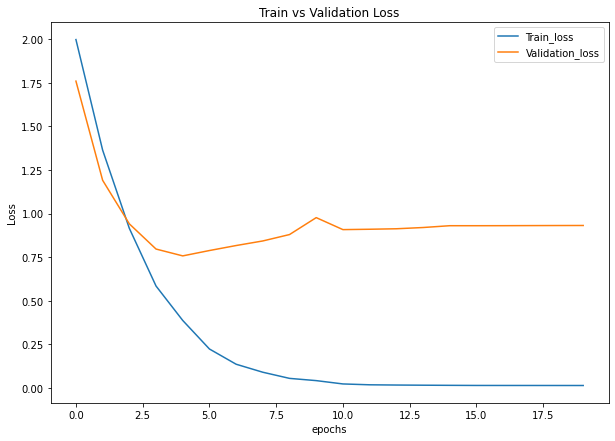

In [84]:
# model = model1
# Evaluate the model 
# model.evaluate(test_data, test_labels)
fig, ax = plt.subplots(figsize = (10, 7))
plt.plot(history.history["loss"], label = "Train_loss")
plt.plot(history.history["val_loss"], label = "Validation_loss")
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.title("Train vs Validation Loss")
plt.legend()
plt.show()

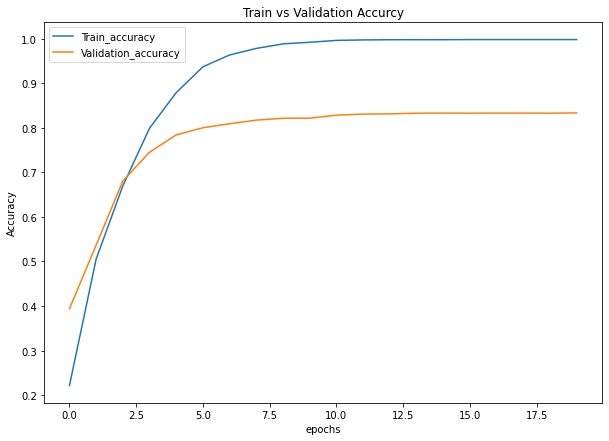

In [85]:
fig, ax = plt.subplots(figsize = (10, 7))
plt.plot(history.history["accuracy"], label = "Train_accuracy")
plt.plot(history.history["val_accuracy"], label = "Validation_accuracy")
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.title("Train vs Validation Accurcy")
plt.legend()
plt.show()

In [ ]:
predictions = model.predict(test_data)
topics = np.array(['World Politics', 'Middle East', 'Other', 'Election Ivestigation', 'Elections','Europe','US Politics','US Protests'])
predictions = topics[np.argmax(predictions, axis=1).reshape(-1)]
real['Topic'] = predictionstopic

# Summary relevant people and organizations

Summarization and extraction of relevant people and organization is done using existing and pretrained packages. Expanding this section further is part of the future work and improvements discussed in the report. 

I am using the `transformers` library for the abstractive summarization. 
`spacy` library for extraction. 


In [ ]:
from collections import Counter
import en_core_web_lg
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration, T5Config

nlp = en_core_web_sm.load()

def summary(text):
    model = T5ForConditionalGeneration.from_pretrained('t5-small')
    tokenizer = T5Tokenizer.from_pretrained('t5-small')
    device = torch.device('cpu')
    preprocess_text = text.strip().replace("\n","")
    t5_prepared_Text = "summarize: "+preprocess_text
    tokenized_text = tokenizer.encode(t5_prepared_Text, return_tensors="pt").to(device)
    
  # summmarize 
    summary_ids = model.generate(tokenized_text,
                                      num_beams=4,
                                      no_repeat_ngram_size=2,
                                      min_length=30,
                                      max_length=800,
                                      early_stopping=True)

    output = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return output

def get_people(text):
    doc = nlp(text)
    ppl = [(ent.text) for ent in doc.ents if ent.label_ == 'PERSON']
    c = Counter(ppl)
    ppl = [c.most_common(3)[i][0] for i in range(min(len(c),3))]
    return ppl

def get_org(text):
    doc = nlp(text)
    org = [(ent.text) for ent in doc.ents if ent.label_ == 'ORG']
    c = Counter(org)
    org = [c.most_common(3)[i][0] for i in range(min(len(c),3))]
    return org

In [ ]:
real['Summary'] = real['text'].apply(lambda x: summary(x))
real['Key People'] = real['text'].apply(lambda x: get_people(x))
real['Key Org'] = real['text'].apply(lambda x: get_org(x))